In [ ]:
#default_exp bs_finder

Example notebook to port batch size finder implemented by DanyWind ([repo V1](https://github.com/DanyWind/fastai_bs_finder) / [blog](https://towardsdatascience.com/implementing-a-batch-size-finder-in-fastai-how-to-get-a-4x-speedup-with-better-generalization-813d686f6bdf) / [discussion](https://forums.fast.ai/t/batch-size-finder-from-openai-implemented-using-fastai/57620)) to fastai2.

Kudos to Muellerzr as I have used his [01_Adults.ipynb notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/01_Adults.ipynb) to bootstrap tabular example :)  and his [course](https://forums.fast.ai/t/a-walk-with-fastai2-vision-study-group-and-online-lectures-megathread/59929).

# Batch size finder callback

In [1]:
#export
from fastai2.basics import *

Helper functions

In [2]:
#export
# Linear combination for the moving average
def _lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2


def _ema_with_debias(avg, beta, yi, i):
    "Exponential moving average with debiasing"
    if avg is None: avg=0
    avg = _lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))


def _get_flatten_grads(model):
    parameters = L(model.parameters())
    grads = [param.grad.flatten().view(-1,1) for param in parameters if not type(param.grad) == type(None)]
    grad = torch.cat(grads)
    return grad    

Batch size finder callback

In [3]:
#export
class BSFinder(Callback):
    """
    Implementation of "An Empirical Model of Large-Batch Training" article to find optimal batch size.
    It helps to find a good batch size to minimaze the training time. However, it may not be a good batch size 
    to minimize the validation loss.
    """
    run_after=Recorder
    
    def __init__(self, num_it:int=None, n_batch=5, beta=0.99, simulate_multi_gpus=True): 
        """
        num_it : the number of batches you want to process, can be set to None and it will automatically train during one epoch (or n_batch if simulate_multi_gpus is se to True)
        n_batch : the number of batches you want to store before computing the Simple Noise Scale. 20 seems to work well across different tasks.
        beta : the beta parameter for an exponential moving average to compute the sum of variances, and the scale of the gradient. If the plot is too irregular, try increasing to 0.999 or more if needed, or increase the n_batch parameter.
        simulate_multi_gpus=Simulate that user has n_batch gpus by iterating without updating model weights as original authors had. Setting it to False use DanyWind aproximation that's faster but numerically more inestable and finds a Simple Noise Scale smaller than the original Simple Noise Scale. 
        """
        store_attr(self, 'num_it, n_batch, beta, simulate_multi_gpus')

    def begin_fit(self):
        # Save original model
        self.learn.save('_tmp')
        
        if not self.num_it: self.num_it = len(self.dls.train) * (self.n_batch if self.simulate_multi_gpus else 1)
        
        self.running_scale = None
        self.running_noise = None
        
        # Use python list instead L fastai list as torch.cat doesn't understand the former
        self.stored_grads = []

        # Here, we will store the results
        self.stats = L()
        self.count=0

    def begin_validate(self): raise CancelValidException()
                
    def after_backward(self):  
        if self.train_iter >= self.num_it: raise CancelFitException()
               
        # Get gradients and store them
        self.stored_grads.append(_get_flatten_grads(self.model))
        
        self.count += 1
        if self.count != len(self.stored_grads):
            breakpoint()

        if self.simulate_multi_gpus and len(self.stored_grads) < self.n_batch: 
            self.opt.zero_grad() # Zero gradients to avoid acumulate them between batches
            #print('a', self.count, self.train_iter, learn.model.embeds[0].weight[0][:3].tolist())
            raise CancelBatchException() #skip weight update
        
        if len(self.stored_grads) == self.n_batch: 
            self.count=0
            #print('b', self.count, self.train_iter, learn.model.embeds[0].weight[0][:3].tolist())
            # We have enough batches to compute Simple Noise Scale ratio.
            
            # We concatenate the batches and empty the buffer
            stored_grads = torch.cat(self.stored_grads, dim=1)
            self.stored_grads.clear()
            
            acc_grads = stored_grads.mean(dim = 1)
        
            # The original implementation uses .mean() although in the original article didn't do it. However, averaging g_big and g_small doesn't affect to noise_scale ratio 
            if self.simulate_multi_gpus: g_small = (stored_grads ** 2).sum(dim=0).mean() 
            else: g_small = (stored_grads[:,-1] ** 2).sum() # .mean()
                
            # print((stored_grads ** 2).sum(dim=0).mean().item(), (stored_grads[:,-1] ** 2).sum().item(), (stored_grads ** 2).sum(dim=0).tolist())
            
            g_big = (acc_grads ** 2).sum() # .mean()
            
            bs = find_bs(self.yb) # or self.dls.train.bs
            b_small, b_big = bs, bs * self.n_batch
        
            noise = (b_big * g_big - b_small * g_small) / (b_big - b_small)
            scale = (g_small - g_big) / ((1 / b_small) - (1 / b_big))

            self.running_scale, scale = _ema_with_debias(self.running_scale,self.beta,scale,self.iter)
            self.running_noise, noise = _ema_with_debias(self.running_noise,self.beta,noise,self.iter)

            scale = scale.item()
            noise = noise.item()
            noise_scale = (scale / noise)
            
            # Save results
            self.stats.append(dict(n_iter=(len(self.stats)) * (1 if self.simulate_multi_gpus else self.n_batch),
                                   noise=noise, scale=scale, noise_scale=noise_scale))
        
    def after_fit(self):
        if self.train_iter < self.num_it: warn(f"Fitting was too short to complete all expectediterations. Please, increase the number of epochs")
            
        tmp_f = self.path/self.model_dir/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load('_tmp')
            os.remove(tmp_f)
        
        if hasattr(self.learn, 'recorder'): 
            # index = pd.Index(torch.arange(1, len(self.stats)+1)*self.n_batch, name='n_iter')
            df = pd.DataFrame(self.stats)#, index=index)
            df.set_index('n_iter', inplace=True)
            self.recorder.bs_find_stats = df

    _docs = {"begin_fit": "Initialize container for search results and auxiliary variables and save the model",
             "after_batch": "Record hyper-parameters of this batch and potentially stop training",
             "after_backward": "Store gradients and compute Simple Noise Scale",
             "begin_validate": "Skip the validation part of training"}
        

Add methods to Recorder and Learner class related to batch size finder callback. 

In [4]:
#export
@patch
def plot_bs_find(self:Recorder):
    "Plot the result of an BS Finder test (won't work if you didn't do `learn.bs_find()` before)"
    fig, ax = plt.subplots(1,1)
    stats = self.bs_find_stats
    ax.plot(stats.index, stats.noise_scale)
    ax.set_ylabel("Simple Noise Scale")
    ax.set_xlabel("# iteration")

In [5]:
#export
@delegates(BSFinder)
@patch
def bs_find(self:Learner, lr, num_it=None, n_batch=5, simulate_multi_gpus=True, show_plot=True, **kwargs):
    """
    Launch a mock training to find a good batch size to minimaze training time. 
    However, it may not be a good batch size to minimize the validation loss. 
    
    A good batch size is where the Simple Noise Scale converge ignoring the small growing trend 
    with the number of iterations if exists. The optimal batch size is about an order the magnitud
    where Simple Noise scale converge. Typically,  the optimial batch size in image classification 
    problems will be 2-3 times lower where 
    """  
    num_it = num_it if num_it else len(self.dls.train)
    num_it *= n_batch if simulate_multi_gpus else 1
    n_epoch = num_it//len(self.dls.train)
    cb=BSFinder(num_it=num_it, n_batch=n_batch, simulate_multi_gpus=simulate_multi_gpus, **kwargs)
    with self.no_logging(): self.fit(n_epoch, lr, cbs=cb)
    if show_plot: self.recorder.plot_bs_find()

# Example

## Data & Dataloaders 

In [6]:
from fastai2.tabular.all import *

In [7]:
path = untar_data(URLs.ADULT_SAMPLE)

In [8]:
df = pd.read_csv(path/'adult.csv')

In [9]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [10]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

In [11]:
splits = RandomSplitter()(range_of(df))

In [12]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

In [13]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [14]:
dls = to.dataloaders()

In [15]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,False,44.000000,109273.001435,10.0,<50k
1,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,False,34.000000,304030.002055,9.0,<50k
2,Local-gov,Some-college,Married-civ-spouse,Exec-managerial,Husband,Black,False,44.000000,181343.999694,10.0,>=50k
3,Private,HS-grad,Divorced,Machine-op-inspct,Not-in-family,White,False,45.000000,135044.001168,9.0,<50k
4,Private,Bachelors,Widowed,Adm-clerical,Not-in-family,White,False,46.000000,206889.000203,13.0,<50k
5,Private,9th,Separated,Craft-repair,Unmarried,White,False,54.000000,38795.005988,5.0,<50k
6,Private,HS-grad,Married-spouse-absent,Adm-clerical,Not-in-family,White,False,30.000000,147430.000373,9.0,<50k
7,Private,10th,Married-civ-spouse,Craft-repair,Husband,White,False,37.000000,236328.000841,6.0,<50k
8,Self-emp-not-inc,Some-college,Married-civ-spouse,Sales,Husband,White,False,63.999999,289740.998328,10.0,<50k
9,Private,Assoc-acdm,Married-civ-spouse,Exec-managerial,Husband,White,False,52.000000,159669.998483,12.0,<50k


## Learner

In [26]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.00363078061491251)

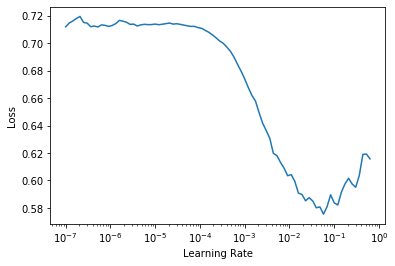

In [27]:
learn.lr_find()

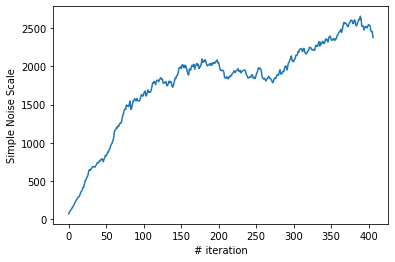

In [28]:
learn.bs_find(lr=1e-3)

Simple Noise Scale has converged around 2000 or 2500. So a good batch size will be 2048 as they are multiple of 8. **Remember**: this batch size is optimized for training speed but **NOT** to minimaze validation error. So, it gives you a reference to the max batch size to use.

Now, we recreate the dataloaders with the good batch size.

In [33]:
optim_dls = to.dataloaders(bs=2048)

In [34]:
learn.dls = optim_dls

Finally, you should use lr_find to find a good learning rate for the chosen batch size as usually the optimal learning rate vary with the batch size. 

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.002511886414140463)

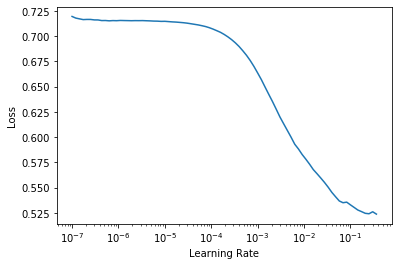

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.648452,0.697304,0.511824,00:00
1,0.518633,0.596584,0.744932,00:00
2,0.452751,0.528755,0.761210,00:00
3,0.419296,0.493071,0.776873,00:00
4,0.398739,0.455735,0.796069,00:00


Compare to non optimized batch size. By default, it's 64.

In [37]:
learn.dls = dls

In [39]:
learn.dls.bs

64

In [38]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.366696,0.354742,0.834767,00:08
1,0.360144,0.351827,0.833538,00:08
2,0.351958,0.345428,0.838145,00:08
3,0.344627,0.340538,0.841830,00:08
4,0.332268,0.340671,0.841216,00:08


We have an infinite speed increase ;) 

Just remember, this batch size is optimized for training speed but **NOT** to minimaze validation error. So, it gives you a reference to the max batch size to use.

# ¿How stable is the batch size finder?

In [40]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

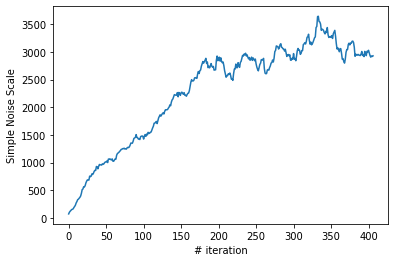

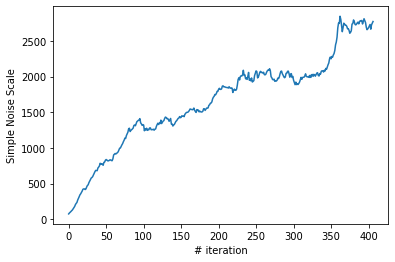

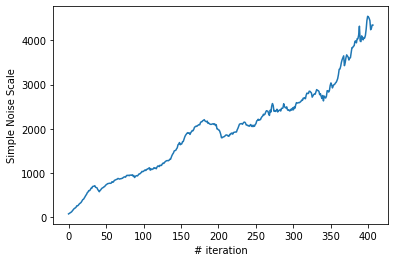

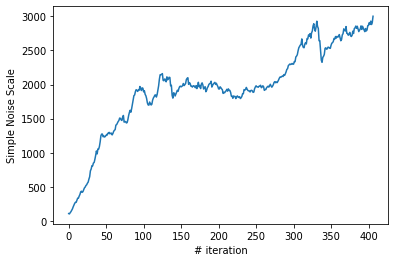

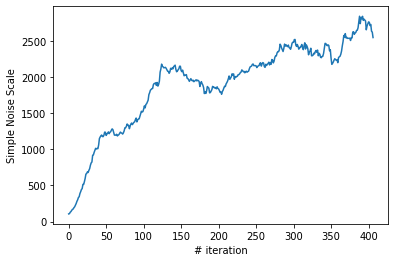

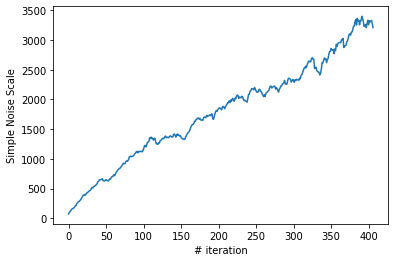

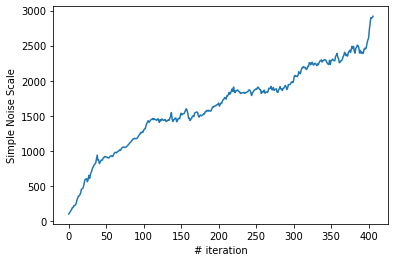

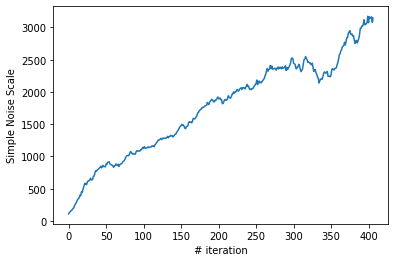

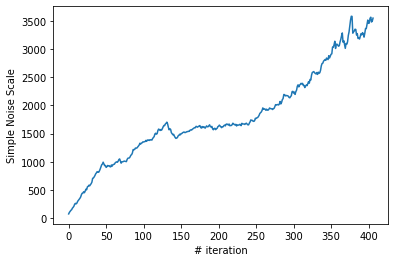

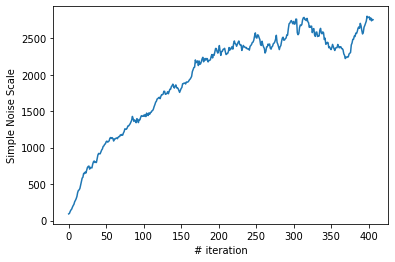

In [41]:
for _ in range(10):
    learn.bs_find(1e-3)
    plt.show()

# Export

In [43]:
from nbdev.imports import *

In [45]:
create_config(".", user='', path='.', cfg_name='settings.ini')

In [49]:
from nbdev.export import *
notebook2script('bs_finder.ipynb', )

FileNotFoundError: [Errno 2] No such file or directory: '/home/twins/Escritorio/Victor/Python/Machine learning/fastai-custom-extensions/batch_finder/_nbdev.py'